In [2]:
import pandas as pd
import re
import nltk
import torch
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [3]:
train_data = pd.read_csv('train.csv')
train_data.head()

id                                               text  sentiment
0  TRAIN_00000  @SenWarren The problem with your massively fla...          2
1  TRAIN_00001  #Tweetlord is a twitter role playing game! Che...          1
2  TRAIN_00002  I just slammed my elbow into a fridge, I did n...          2
3  TRAIN_00003                          _beckett Thanks so much !          1
4  TRAIN_00004                     My gauge fell out on superman           2

In [4]:
test_data = pd.read_csv('test.csv')
test_data.head()

id                                               text
0  TEST_00000  @naima @dialogician Most of this footage is fr...
1  TEST_00001  @Haggis_UK @kevinhollinrake is willing to brea...
2  TEST_00002  ‚ÄòNo Magic Bullet‚Äô for Preserving Abortion Acce...
3  TEST_00003               Can I also have a swirly flat white?
4  TEST_00004  Question: If the trains we have get disabled i...

In [5]:
print(len(train_data))
print(len(test_data))

32000
48000


Text(0, 0.5, 'sentiment')

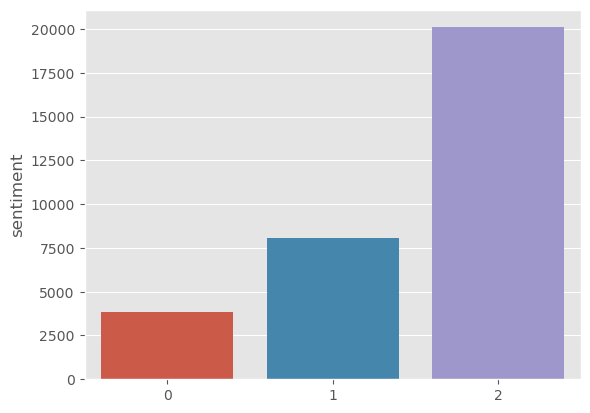

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò 'sentiment' Ïª¨ÎüºÏùò Í∞í Î∂ÑÌè¨Î•º Ïπ¥Ïö¥Ìä∏Ìï©ÎãàÎã§.
x = train_data.sentiment.value_counts()
# x.indexÎäî Ïú†ÎãàÌÅ¨Ìïú 'sentiment' Í∞íÎì§Ïù¥Í≥†, x.valuesÎäî Í∞Å Í∞íÏùò ÎπàÎèÑÏàòÏûÖÎãàÎã§.
sns.barplot(x=x.index, y=x.values)
plt.gca().set_ylabel('sentiment')

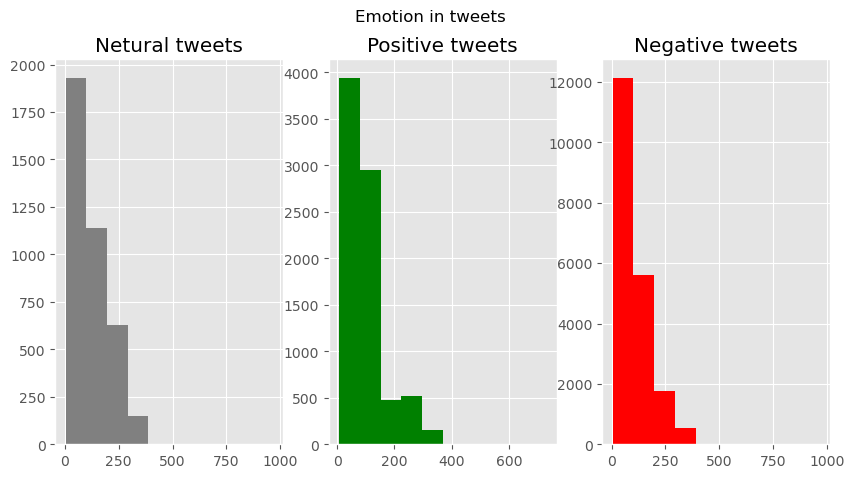

In [7]:
# Exploratory Data Analysis of tweets
# sentiment Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌÖçÏä§Ìä∏ Í∏∏Ïù¥Î•º ÎπÑÍµêÌïòÍ∏∞ ÏúÑÌïú ÌÉêÏÉâÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù(Exploratory Data Analysis, EDA)
# 0-Netural, 1-Positive, 2-Negative

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

train_data_len = train_data[train_data['sentiment']==0]['text'].str.len()
ax1.hist(train_data_len, color='gray')
ax1.set_title('Netural tweets')

train_data_len = train_data[train_data['sentiment']==1]['text'].str.len()
ax2.hist(train_data_len, color='green')
ax2.set_title('Positive tweets')

train_data_len = train_data[train_data['sentiment']==2]['text'].str.len()
ax3.hist(train_data_len, color='red')
ax3.set_title('Negative tweets')

fig.suptitle('Emotion in tweets')
plt.show()

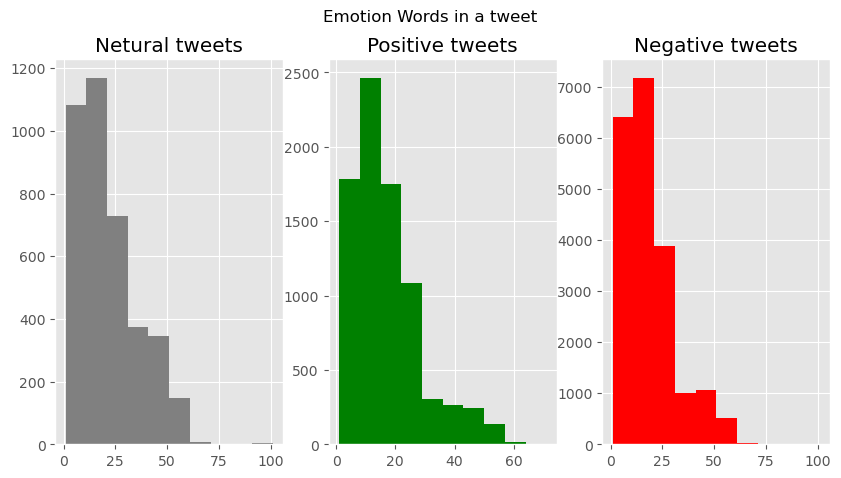

In [8]:
# Number of words in a tweet¬∂
# sentiment Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Ìä∏ÏúóÎãπ Îã®Ïñ¥Ïùò ÏàòÎ•º ÎπÑÍµêÌïòÍ∏∞ ÏúÑÌïú ÌÉêÏÉâÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù(Exploratory Data Analysis, EDA)
# 0-Netural, 1-Positive, 2-Negative

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

train_data_len=train_data[train_data['sentiment']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_data_len, color='gray')
ax1.set_title('Netural tweets')

train_data_len=train_data[train_data['sentiment']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_data_len, color='green')
ax2.set_title('Positive tweets')

train_data_len=train_data[train_data['sentiment']==2]['text'].str.split().map(lambda x: len(x))
ax3.hist(train_data_len, color='red')
ax3.set_title('Negative tweets')

fig.suptitle('Emotion Words in a tweet')
plt.show()


/var/folders/3_/x71n0dfx597b2bmnkl6m82hm0000gn/T/ipykernel_16483/398297835.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='gray')
/var/folders/3_/x71n0dfx597b2bmnkl6m82hm0000gn/T/ipykernel_16483/398297835.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

Text(0.5, 0.98, 'Average word length in each tweet')

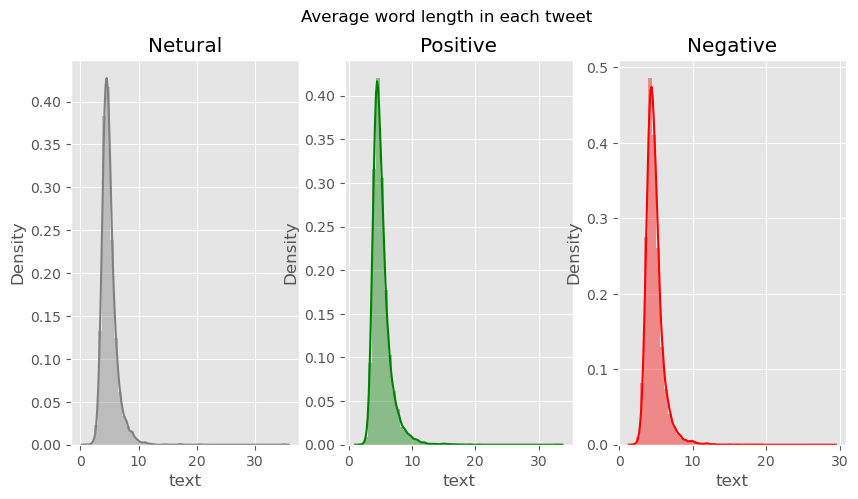

In [9]:
import numpy as np
# Average word length in a tweet
#  sentiment Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Í∞ÑÏóê Ìä∏ÏúóÎãπ ÌèâÍ∑† Îã®Ïñ¥ Í∏∏Ïù¥Î•º ÎπÑÍµêÌïòÍ∏∞ ÏúÑÌïú
# ÌÉêÏÉâÏ†Å Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù(Exploratory Data Analysis, EDA)ÏùÑ ÏàòÌñâ

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

word=train_data[train_data['sentiment']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='gray')
ax1.set_title('Netural')

word=train_data[train_data['sentiment']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Positive')

word=train_data[train_data['sentiment']==2]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='red')
ax3.set_title('Negative')

fig.suptitle('Average word length in each tweet')

In [10]:
# tweet Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò target Í∞íÏóê Îî∞Î•∏ Î™®Îì† Îã®Ïñ¥Îì§Ïùò Î™©Î°ù(ÎòêÎäî corpus)ÏùÑ ÏÉùÏÑ±
def create_corpus(sentiment):
    corpus=[]
    
    for x in train_data[train_data['sentiment']==sentiment]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daehyunkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from collections import defaultdict

# Common stopwords in tweets
# tweet Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú sentiment Í∞íÏù¥ 0Ïù∏ Ìä∏ÏúóÎì§Ïùò ÌÖçÏä§Ìä∏ÏóêÏÑú
# Í∞ÄÏû• ÌùîÌïòÍ≤å Îì±Ïû•ÌïòÎäî Î∂àÏö©Ïñ¥(stopwords)Î•º Ï∞æÎäî Ïó≠Ìï†

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

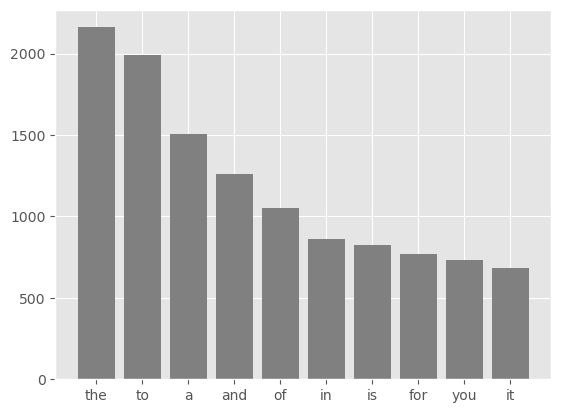

In [13]:
x,y=zip(*top)
plt.bar(x,y, color='gray')

<BarContainer object of 10 artists>

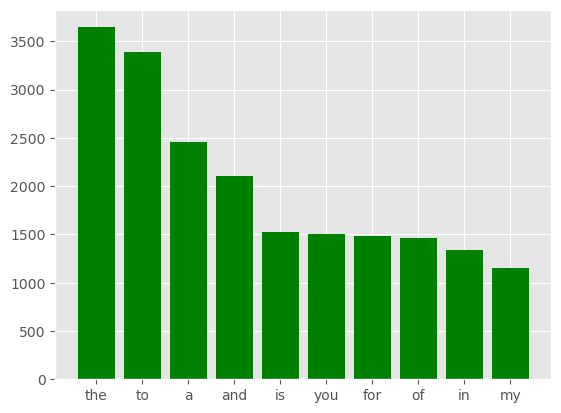

In [14]:
# tweet Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú sentiment Í∞íÏù¥ 1Ïù∏ Ìä∏ÏúóÎì§Ïùò
# ÌÖçÏä§Ìä∏ÏóêÏÑú Í∞ÄÏû• ÌùîÌïòÍ≤å Îì±Ïû•ÌïòÎäî Î∂àÏö©Ïñ¥(stopwords)Î•º Ï∞æÍ≥†, Í∑∏Í≤ÉÏùÑ Î∞î Ï∞®Ìä∏Î°ú ÏãúÍ∞ÅÌôîÌïòÎäî Ïó≠Ìï†
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y, color='green')

<BarContainer object of 10 artists>

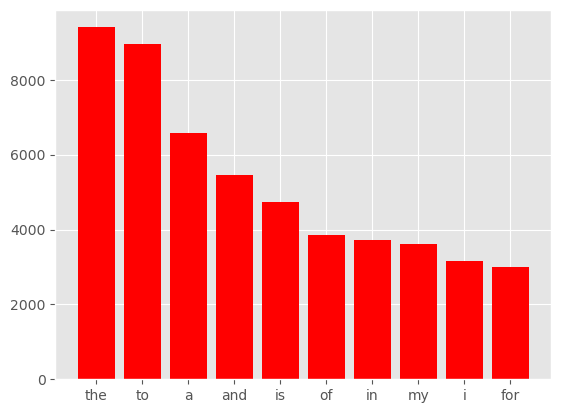

In [15]:
# tweet Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú sentiment Í∞íÏù¥ 2Ïù∏ Ìä∏ÏúóÎì§Ïùò
# ÌÖçÏä§Ìä∏ÏóêÏÑú Í∞ÄÏû• ÌùîÌïòÍ≤å Îì±Ïû•ÌïòÎäî Î∂àÏö©Ïñ¥(stopwords)Î•º Ï∞æÍ≥†, Í∑∏Í≤ÉÏùÑ Î∞î Ï∞®Ìä∏Î°ú ÏãúÍ∞ÅÌôîÌïòÎäî Ïó≠Ìï†
corpus=create_corpus(2)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y, color='red')

<BarContainer object of 24 artists>

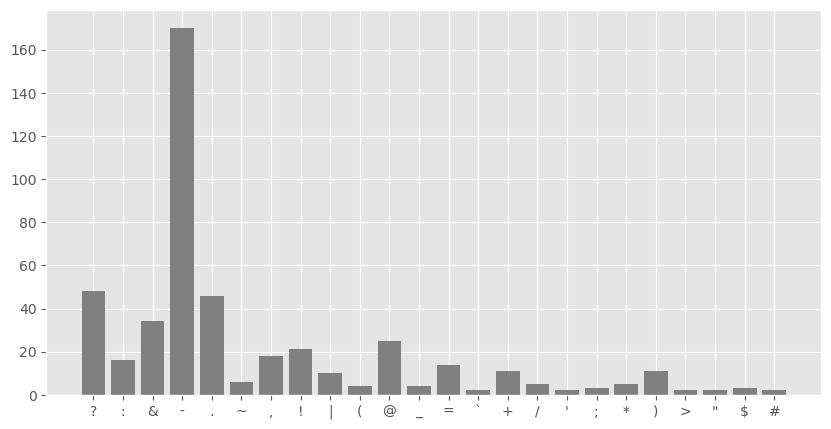

In [16]:
# Analyzing punctuations.
# sentiment Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú target Í∞íÏù¥ 0Ïù∏ Ìä∏ÏúóÎì§Ïùò ÌÖçÏä§Ìä∏ÏóêÏÑú
# ÌäπÏàòÎ¨∏Ïûê(Íµ¨ÎëêÏ†ê)Ïùò Îì±Ïû• ÎπàÎèÑÎ•º Î∂ÑÏÑùÌïòÍ≥†, Í∑∏ Í≤∞Í≥ºÎ•º Î∞î Ï∞®Ìä∏Î°ú ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='gray')

<BarContainer object of 23 artists>

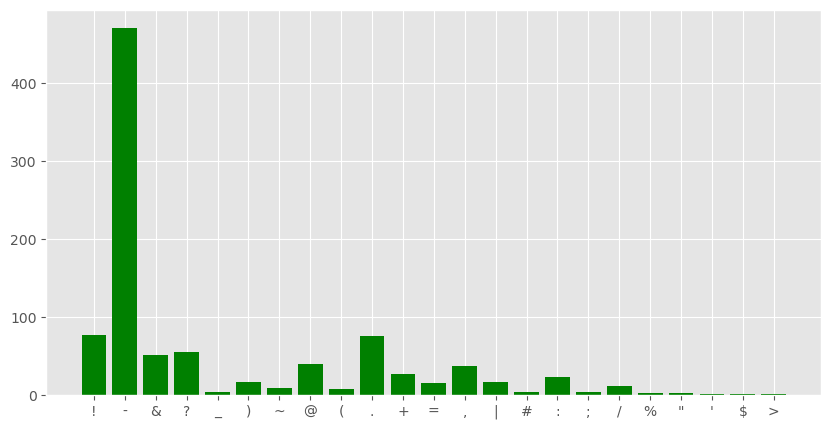

In [17]:
# Analyzing punctuations.
# sentiment Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú target Í∞íÏù¥ 1Ïù∏ Ìä∏ÏúóÎì§Ïùò ÌÖçÏä§Ìä∏ÏóêÏÑú
# ÌäπÏàòÎ¨∏Ïûê(Íµ¨ÎëêÏ†ê)Ïùò Îì±Ïû• ÎπàÎèÑÎ•º Î∂ÑÏÑùÌïòÍ≥†, Í∑∏ Í≤∞Í≥ºÎ•º Î∞î Ï∞®Ìä∏Î°ú ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='green')

<BarContainer object of 27 artists>

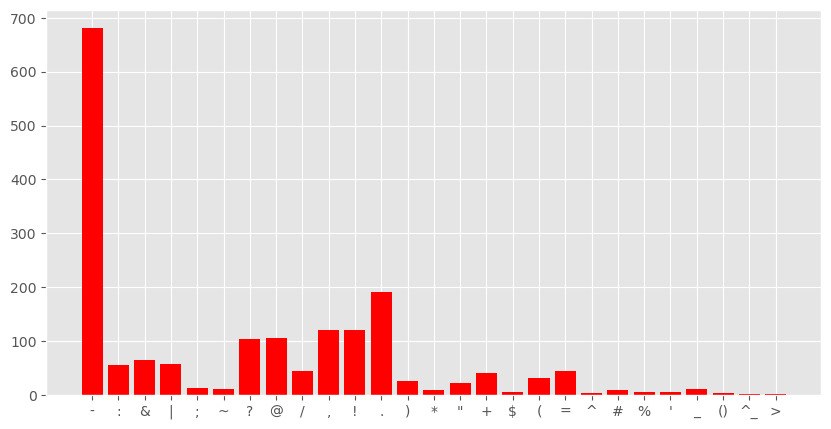

In [18]:
# Analyzing punctuations.
# sentiment Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú target Í∞íÏù¥ 2Ïù∏ Ìä∏ÏúóÎì§Ïùò ÌÖçÏä§Ìä∏ÏóêÏÑú
# ÌäπÏàòÎ¨∏Ïûê(Íµ¨ÎëêÏ†ê)Ïùò Îì±Ïû• ÎπàÎèÑÎ•º Î∂ÑÏÑùÌïòÍ≥†, Í∑∏ Í≤∞Í≥ºÎ•º Î∞î Ï∞®Ìä∏Î°ú ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10,5))
corpus=create_corpus(2)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='red')

In [19]:
from collections import Counter

# tweet Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú target Í∞íÏù¥ 0Ïù∏ Ìä∏ÏúóÎì§Ïùò
# ÌÖçÏä§Ìä∏ÏóêÏÑú Í∞ÄÏû• ÌùîÌïòÍ≤å Îì±Ïû•ÌïòÎäî Îã®Ïñ¥Îì§ÏùÑ Ï∞æÎäî Ïó≠Ìï†. Î∂àÏö©Ïñ¥(stopwords)Îäî Ï†úÏô∏
# common words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Axes: >

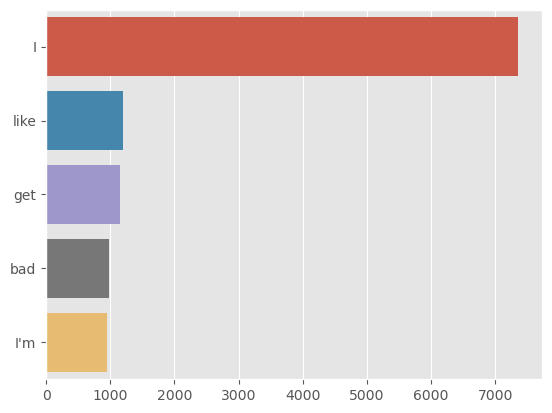

In [20]:
sns.barplot(x=y,y=x)

In [21]:
# Ï£ºÏñ¥ÏßÑ ÌÖçÏä§Ìä∏(corpus)Ïùò Î∞îÏù¥Í∑∏Îû®(bigrams, Ïó∞ÏÜçÎêú Îëê Îã®Ïñ¥Ïùò Ï°∞Ìï©) Î∂ÑÏÑùÏùÑ ÏàòÌñâÌïòÍ≥†,
# Í∞ÄÏû• ÎπàÎ≤àÌïòÍ≤å Îì±Ïû•ÌïòÎäî Î∞îÏù¥Í∑∏Îû®ÏùÑ Î∞òÌôò
# Ngram analysis
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

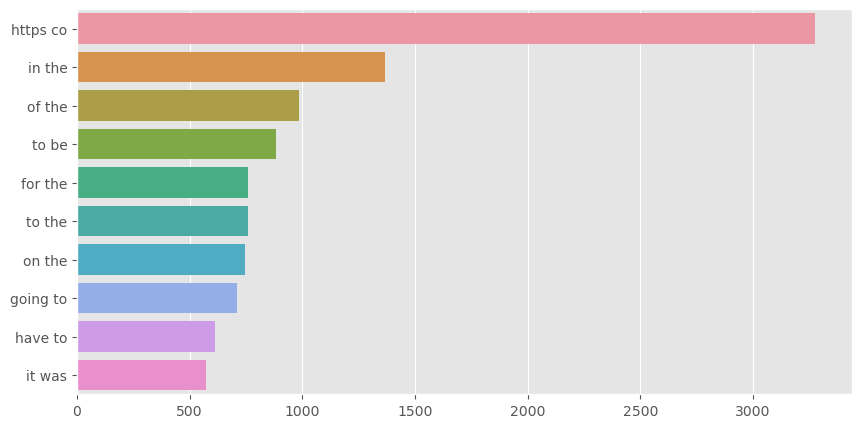

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

plt.figure(figsize=(10,5))
top_bigrams=get_top_bigrams(train_data['text'])[:10]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

In [25]:
# Data Cleaning
# train Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÍ≥º test Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÏàòÏßÅÏúºÎ°ú Í≤∞Ìï© ÌõÑ ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ dfÎ•º ÏÉùÏÑ±
# Í∑∏ Í≤∞Í≥º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò ÌòïÌÉú(shape)Î•º Ï∂úÎ†•
df=pd.concat([train_data,test_data])
df.shape

(80000, 3)

### Ï†ÑÏ≤òÎ¶¨

In [26]:
# Removing urls
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [27]:
# URL Tag Ï†úÍ±∞
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [28]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [29]:
# Removing HTML tags
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [30]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [31]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [32]:
# Romoving Emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake üòîüòî")

'Omg another Earthquake '

In [33]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [49]:
# Removing punctuations, Ï£ºÏñ¥ÏßÑ Íµ¨ÎëêÏ†ê Ï†úÍ±∞
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="#I am a #king"
print(remove_punct(example))

I am a king


In [35]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [36]:
# Removing @, Ï£ºÏñ¥ÏßÑ @ Ï†úÍ±∞
def remove_commercial_at(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="@bigbread, @bigbread"
print(remove_commercial_at(example))

bigbread bigbread


In [37]:
df['text']=df['text'].apply(lambda x : remove_commercial_at(x))

### ÌÖçÏä§Ìä∏ Ï≤†Ïûê Ïò§Î•ò ÏàòÏ†ï

In [38]:
pip install pyspellchecker

Note: you may need to restart the kernel to use updated packages.


In [39]:
# ÌÖçÏä§Ìä∏Ïùò Ï≤†Ïûê Ïò§Î•òÎ•º ÏàòÏ†ïÌïòÎäî Ìï®Ïàò
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [56]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize

# GloVe for Vectorization
# Ï†ÑÏ≤òÎ¶¨ ÌïòÏó¨ corpus(Îã®Ïñ¥Ïùò ÏßëÌï©)ÏùÑ ÏÉùÏÑ±

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [57]:
corpus=create_corpus(df)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 80000/80000 [00:03<00:00, 23482.59it/s]


In [58]:
# GloVe (Global Vectors for Word Representation)Ïùò ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Îã®Ïñ¥ Î≤°ÌÑ∞Î•º Î°úÎìú

embedding_dict={}
with open('glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [59]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# corpusÎ•º ÌÜ†ÌÅ∞ÌôîÌïòÍ≥† Í∞Å ÌÖçÏä§Ìä∏Î•º Í≥†Ï†ï Í∏∏Ïù¥Ïùò Ïà´Ïûê ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

train_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [60]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 101887


In [63]:
# Keras TokenizerÎ°úÎ∂ÄÌÑ∞ ÏñªÏùÄ Îã®Ïñ¥ Ïù∏Îç±Ïä§(word_index)ÏôÄ GloVeÏùò ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú ÏûÑÎ≤†Îî©(embedding_dict)
# ÏÇ¨Ïö©ÌïòÏó¨ Í∞Å Îã®Ïñ¥Ïóê ÎåÄÌïú ÏûÑÎ≤†Îî© ÌñâÎ†¨(embedding_matrix)ÏùÑ Íµ¨ÏÑ±

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,200))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 101887/101887 [00:00<00:00, 892470.15it/s]


In [64]:
train=train_data[:train_data.shape[0]]
test=train_data[train_data.shape[0]:]

In [65]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌï† & ÌïôÏäµ
X_train,X_test,Y_train,Y_test=train_test_split(train,train_data['sentiment'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of test",X_test.shape)

Shape of train (27200, 3)
Shape of test (4800, 3)


In [66]:
print(train)

                id                                               text  \
0      TRAIN_00000  @SenWarren The problem with your massively fla...   
1      TRAIN_00001  #Tweetlord is a twitter role playing game! Che...   
2      TRAIN_00002  I just slammed my elbow into a fridge, I did n...   
3      TRAIN_00003                          _beckett Thanks so much !   
4      TRAIN_00004                     My gauge fell out on superman    
...            ...                                                ...   
31995  TRAIN_31995  Its a grey day over Manchester  i would like t...   
31996  TRAIN_31996  Got laidoff tonight. Very unhappy.  time for bed.   
31997  TRAIN_31997  @MonicaLewinsky Wonderful Monica. Chef‚Äôs kiss ...   
31998  TRAIN_31998  #AR #business card\n#VR #MixedReality #IoT #in...   
31999  TRAIN_31999  @Luscious_Dream (When you move your wrist, my ...   

       sentiment  
0              2  
1              1  
2              2  
3              1  
4              2  
...    

In [67]:
# BERT ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î∞è Ïù∏ÏΩîÎî©
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î•º BERT Î™®Îç∏Ïóê ÎßûÍ≤å Î≥ÄÌôò
X_train = tokenizer(train_data['text'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
Y_train = tokenizer(test_data['text'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

# Î†àÏù¥Î∏î Îç∞Ïù¥ÌÑ∞
train_labels = torch.tensor(train_data['sentiment'].values)


In [68]:
# Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], X_train['token_type_ids'], train_labels)

# DataLoader ÏÑ§Ï†ï
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [69]:
# BERT Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 'num_labels'Îäî ÌÅ¥ÎûòÏä§ ÏàòÏóê ÎßûÍ≤å ÏÑ§Ï†ï
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [70]:
import datetime

# ÌïôÏäµ Î£®ÌîÑ
for epoch in range(epochs):
    start_time = datetime.datetime.now()
    
    print(f"Epoch {epoch+1}/{epochs}")
    print('-' * 50)
    
    model.train()
    total_loss = 0
    progress = 0  # Î∞∞ÏπòÏùò ÏßÑÌñâÎèÑÎ•º Ï∂îÏ†ÅÌïòÍ∏∞ ÏúÑÌïú Î≥ÄÏàò
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'token_type_ids': batch[2], 'labels': batch[3]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        # ÏùºÏ†ï Î∞∞Ïπò Í∞ÑÍ≤©ÎßàÎã§ ÏÜêÏã§ÏùÑ Ï∂úÎ†•Ìï©ÎãàÎã§.
        progress += 1
        if progress % 20 == 0:  # 20Î∞∞ÏπòÎßàÎã§ ÏßÑÌñâ ÏÉÅÌô© Ï∂úÎ†• (ÏõêÌïòÎäî Ïà´ÏûêÎ°ú Î≥ÄÍ≤Ω Í∞ÄÎä•)
            print(f"Batch {progress}/{len(train_dataloader)} - Loss: {loss.item():.4f}")
            
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # Í∞Å epochÏùò ÏÜåÏöî ÏãúÍ∞Ñ Í≥ÑÏÇ∞
    end_time = datetime.datetime.now()
    elapsed_time = end_time - start_time
    remaining_time = elapsed_time * (epochs - (epoch + 1))
    
    print(f"Time taken for epoch {epoch+1}: {elapsed_time}")
    print(f"Estimated time remaining for training: {remaining_time}")
    print('\n')
    
    # Í≤ÄÏ¶ù Î∞è ÌèâÍ∞Ä ÏΩîÎìúÎ•º Ïó¨Í∏∞Ïóê Ï∂îÍ∞ÄÌï† Ïàò ÏûàÏäµÎãàÎã§.


Epoch 1/4
--------------------------------------------------
Batch 20/1000 - Loss: 1.0112
Batch 40/1000 - Loss: 0.6600
Batch 60/1000 - Loss: 0.7413
Batch 80/1000 - Loss: 0.8398
Batch 100/1000 - Loss: 0.6634
Batch 120/1000 - Loss: 0.5557
Batch 140/1000 - Loss: 0.6122
Batch 160/1000 - Loss: 0.8275
Batch 180/1000 - Loss: 0.8559
Batch 200/1000 - Loss: 0.7372
Batch 220/1000 - Loss: 0.5002
Batch 240/1000 - Loss: 0.5457
Batch 260/1000 - Loss: 0.5341
Batch 280/1000 - Loss: 0.5160
Batch 300/1000 - Loss: 0.7178
Batch 320/1000 - Loss: 0.7609
Batch 340/1000 - Loss: 0.5939
Batch 360/1000 - Loss: 0.3783
Batch 380/1000 - Loss: 0.6452
Batch 400/1000 - Loss: 0.3025
Batch 420/1000 - Loss: 0.5554
Batch 440/1000 - Loss: 0.5241
Batch 460/1000 - Loss: 0.5651
Batch 480/1000 - Loss: 0.4059
Batch 500/1000 - Loss: 0.6527
Batch 520/1000 - Loss: 0.3546
Batch 540/1000 - Loss: 0.3867
Batch 560/1000 - Loss: 0.3153
Batch 580/1000 - Loss: 0.4200
Batch 600/1000 - Loss: 0.6677
Batch 620/1000 - Loss: 0.3581
Batch 640/100

In [71]:
print(X_test.columns)

Index(['id', 'text', 'sentiment'], dtype='object')


In [72]:
print(type(X_train))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [73]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [74]:
print(X_test.columns)

Index(['id', 'text', 'sentiment'], dtype='object')


In [75]:
from transformers import BertTokenizer

# BERT ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# X_test ÌÜ†ÌÅ∞Ìôî
encoded_test = tokenizer(list(X_test['text']), truncation=True, padding=True, return_tensors="pt")

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î•º DataLoaderÎ°ú Î≥ÄÌôò
test_dataset = TensorDataset(encoded_test['input_ids'], encoded_test['attention_mask'], encoded_test['token_type_ids'])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [76]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [77]:
print(len(test_data))

48000


`X_test` Î≥ÄÏàòÏùò ÌÉÄÏûÖÏù¥ Î≥ÄÌïòÏßÄ ÏïäÎäî Í≤ÉÏùÄ ÎãπÏó∞Ìï©ÎãàÎã§. ÏúÑÏùò ÏΩîÎìúÏóêÏÑú `X_test` ÏûêÏ≤¥Î•º Î≥ÄÍ≤ΩÌïòÏßÄ ÏïäÏïòÍ∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§. ÎåÄÏã† `encoded_test`Ïóê ÌÜ†ÌÅ∞ÌôîÎêú Í≤∞Í≥ºÍ∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.

`X_test`Îäî ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Í∞ÄÏßÄÍ≥† ÏûàÎäî pandas DataFrameÏù¥Í≥†, Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º BERT ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥ºÎäî `encoded_test`Ïóê Ï†ÄÏû•Îê©ÎãàÎã§. Í∑∏Î¶¨Í≥† `test_dataset`ÏùÄ Ïù¥ `encoded_test`Î•º Í∏∞Î∞òÏúºÎ°ú ÏÉùÏÑ±Îê©ÎãàÎã§.

Îî∞ÎùºÏÑú Îã§Ïùå ÏûëÏóÖÏùÑ Ìï† Îïå `X_test`Î•º Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏù¥ ÏïÑÎãàÎùº, `test_dataset` ÌòπÏùÄ `encoded_test`Î•º ÏÇ¨Ïö©ÌïòÏÖîÏïº Ìï©ÎãàÎã§.

ÏöîÏïΩÌïòÎ©¥:
- `X_test`: ÏõêÎ≥∏ ÌÖçÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î•º Ìè¨Ìï®ÌïòÎäî pandas DataFrameÏûÖÎãàÎã§.
- `encoded_test`: `X_test`Î•º BERT ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ°ú ÌÜ†ÌÅ∞ÌôîÌïú Í≤∞Í≥ºÏûÖÎãàÎã§.
- `test_dataset`: `encoded_test`Î•º Í∏∞Î∞òÏúºÎ°ú ÏÉùÏÑ±Îêú PyTorch DatasetÏûÖÎãàÎã§.

ÌòÑÏû¨ Îã®Í≥ÑÏóêÏÑúÎäî `X_test`Ïùò ÌÉÄÏûÖÏùÑ Î∞îÍæ∏ÏßÄ ÏïäÏïÑÎèÑ Í¥úÏ∞ÆÏäµÎãàÎã§. ÌïµÏã¨ÏùÄ ÌÜ†ÌÅ∞ÌôîÎêú Í≤∞Í≥º (`encoded_test` ÎòêÎäî `test_dataset`)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌïòÍ±∞ÎÇò ÏòàÏ∏°ÌïòÎäî Îì±Ïùò ÏûëÏóÖÏùÑ ÏàòÌñâÌï¥Ïïº Ìï©ÎãàÎã§.

In [78]:
# BERT ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ°ú test_data ÌÜ†ÌÅ∞Ìôî
encoded_test = tokenizer(list(test_data['text']), truncation=True, padding=True, return_tensors="pt")

# ÌÜ†ÌÅ∞ÌôîÎêú Í≤∞Í≥ºÎ•º DataLoaderÎ°ú Î≥ÄÌôò
test_dataset = TensorDataset(encoded_test['input_ids'], encoded_test['attention_mask'], encoded_test['token_type_ids'])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(len(test_dataset))

48000


In [85]:
from tqdm import tqdm

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò ÏòàÏ∏°
model.eval()
predictions = []

for batch in tqdm(test_dataloader, desc="Predicting"):
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'token_type_ids': batch[2]}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions.extend(logits.argmax(dim=1).tolist())
    
print(len(predictions))

Predicting: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1500/1500 [1:43:45<00:00,  4.15s/it]

48000


In [86]:
if len(predictions) == len(test_data):
    print("Í∏∏Ïù¥Í∞Ä ÏùºÏπòÌï©ÎãàÎã§.")
else:
    print(f"Í∏∏Ïù¥ Î∂àÏùºÏπò! ÏòàÏ∏° Í∏∏Ïù¥: {len(predictions)}, test_data Í∏∏Ïù¥: {len(test_data)}")

Í∏∏Ïù¥Í∞Ä ÏùºÏπòÌï©ÎãàÎã§.


In [87]:
# f1 score Ï∂úÎ†•
true_labels = test_data['sentiment'].tolist()
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1:.4f}")

KeyError: 'sentiment'

In [88]:
test_data['sentiment'] = predictions
test_data[['id', 'sentiment']].to_csv('bert_submission.csv', index=False)